In [7]:
!pip install mysql-connector-python


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
pip install seaborn

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="127.0.0.1",username="root",password="root",database="ecommerce")
cur=db.cursor()

# List all unique cities where customers are located. 


In [22]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_city'])
df

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
"total order placed in 2017",data [0][0]   # 0 index of data and again index 

('total order placed in 2017', 270606)

# Find the total sales per category.

In [24]:
query=""" select p.product_category,round(sum(pmt.payment_value),2) sales from products as p join orders_items as ot 
on ot.product_id=p.product_id
join payments as pmt on pmt.order_id=ot.order_id group by p.product_category """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['product_category','sales'])
df


,product_category,sales
0,Art,743830.32
1,Cool Stuff,18712752.00
2,Games consoles,4691529.10
3,telephony,11685169.22
4,sport leisure,33411061.42
...,...,...
69,cds music dvds,28786.32
70,La Cuisine,69924.72
71,Fashion Children's Clothing,18856.08
72,PC Gamer,52186.32


# Calculate the percentage of orders that were paid in installments

In [31]:
query=""" select (sum(case when payment_installments>=1 then 1 else 0 end ))/count(*)*100 from payments """
cur.execute(query)
data=cur.fetchall()
data[0][0]

Decimal('99.9981')

# Count the number of customers from each state. 

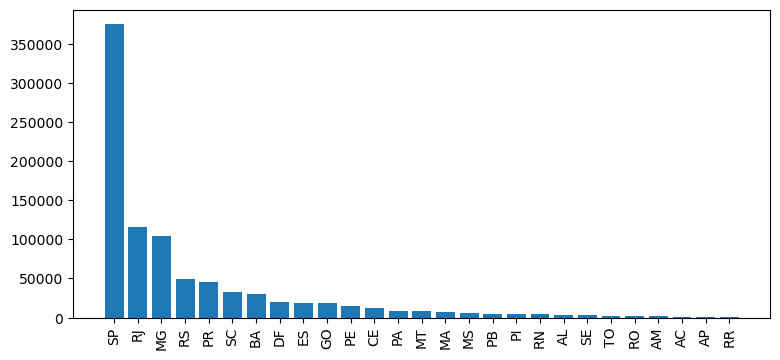

In [45]:
query=""" select customer_state,count(customer_id) from customers group by customer_state """
cur.execute(query)
data=cur.fetchall()
dataframe=pd.DataFrame(data,columns=['state','customer_count'])
dataframe=dataframe.sort_values(by="customer_count", ascending=False)
dataframe

plt.figure(figsize=(9,4))
plt.bar(dataframe['state'],dataframe['customer_count'])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

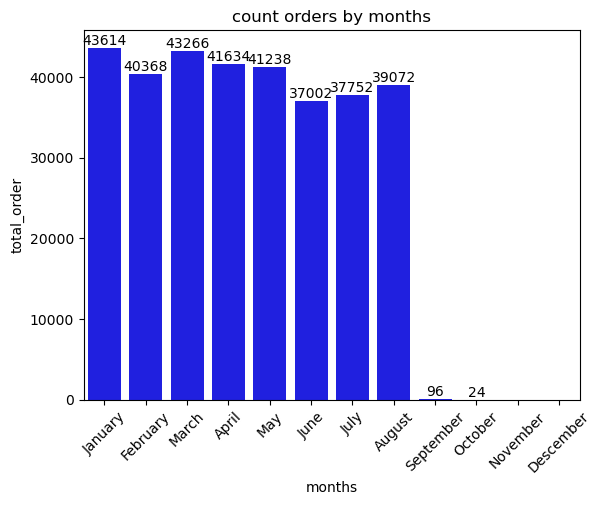

In [122]:
query=""" select monthname(order_purchase_timestamp) as months,count(order_id) as total_order from orders where year(order_purchase_timestamp)=2018 
group by monthname(order_purchase_timestamp) """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","total_order"])
o=['January','February','March','April','May','June','July','August','September','October','November','Descember']



ax=sns.barplot(x=df['months'],y=df['total_order'],data=df,order=o,color='blue')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count orders by months")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [49]:
query=""" with count_per_order as(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc from orders join order_items
on orders.order_id=order_items.order_id group by orders.order_id,orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc),2) avg_orders from customers join count_per_order on customers.customer_id
=count_per_order.customer_id group by customers.customer_city """
cur.execute(query)
df=cur.fetchall()
pd.DataFrame(df,columns=['customer_city','avg_order'])

,customer_city,avg_order
0,treze tilias,22.91
1,indaial,20.08
2,sao jose dos campos,20.49
3,sao paulo,20.81
4,porto alegre,21.15
...,...,...
4105,tibau do sul,18.00
4106,sao mamede,18.00
4107,guairaca,36.00
4108,sambaiba,18.00


# Calculate the percentage of total revenue contributed by each product category.

In [160]:
query=""" select p.product_category,round(sum(pmt.payment_value)/(select sum(payment_value) from payments)*100,2)
   sales from products as p join orders_items as ot 
on ot.product_id=p.product_id
join payments as pmt on pmt.order_id=ot.order_id group by p.product_category """

cur.execute(query)
df=cur.fetchall()
data=pd.DataFrame(df,columns=['product','percentage_sale'])
data

,product,percentage_sale
0,Art,0.77
1,Cool Stuff,19.48
2,Games consoles,4.88
3,telephony,12.17
4,sport leisure,34.78
...,...,...
69,cds music dvds,0.03
70,La Cuisine,0.07
71,Fashion Children's Clothing,0.02
72,PC Gamer,0.05


# Identify the correlation between product price and the number of times a product has been purchased

In [186]:
import numpy as np
query="""select p.product_category,count(oi.product_id) as purchase,round(avg(oi.price),2) avg_price from order_items as oi join products as p on 
oi.product_id=p.product_id group by p.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['product_category','order_count','avg_price'])
df

arr1=df['order_count']
arr2=df['avg_price']
a=np.corrcoef([arr1,arr2]) # to chk order bada to price ghata ya order ghata to price bada 
print("correlation value between order_count and avg_price is :",a[0][-1])

correlation value between order_count and avg_price is : -0.10631514167157566


# Calculate the total revenue generated by each seller, and rank them by revenue.

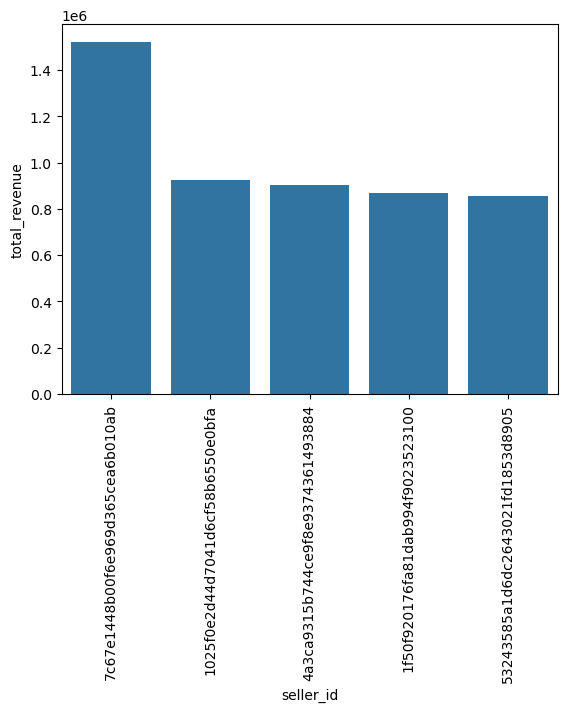

In [200]:
query="""select *,dense_rank() over(order by total_revenue desc) as rank_revenue  from 
 (select oi.seller_id,round(sum(p.payment_value),2) as total_revenue
 from order_items oi
 join payments p on oi.order_id=p.order_id group by oi.seller_id) as a;  """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['seller_id','total_revenue','rank_revenue'])
df=df.head()
sns.barplot(x="seller_id",y="total_revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [214]:
query=""" select customer_id,order_purchase_timestamp,payment,avg(payment) over(partition by customer_id order by 
order_purchase_timestamp rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment from payments join orders 
on payments.order_id=orders.order_id) as a """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','order_purchase_timestamp','payment','mov_avg'])
df.head(65)

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
60,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
61,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
62,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
63,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006


# Calculate the cumulative sales per month for each year.

In [235]:
query=""" select years,months,payment,sum(payment) over(order by months,years) as cum_sum from 
(select month(orders.order_purchase_timestamp) as months,year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments on orders.order_id=payments.order_id group by years,months
order by years,months) as a """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['years','monts','payment','cum_sum'])
df

,years,monts,payment,cum_sum
0,2017,1,2908248.84,2.908249e+06
1,2018,1,23415087.76,2.632334e+07
2,2017,2,6130068.20,3.245340e+07
3,2018,2,20841730.14,5.329513e+07
4,2017,3,9447135.59,6.274227e+07
5,2018,3,24352694.51,8.709497e+07
6,2017,4,8773548.62,9.586851e+07
7,2018,4,24376495.09,1.202450e+08
8,2017,5,12451295.22,1.326963e+08
9,2018,5,24233625.17,1.569299e+08


# Calculate the year-over-year growth rate of total sales.

In [53]:
query=""" with a as(select year(o.order_purchase_timestamp) years, round(sum(p.payment_value),2) total_sale from orders o join payments p
on o.order_id=p.order_id group by years) 
select years,total_sale,((total_sale-lag(total_sale,1) over(order by years))/lag(total_sale,1)over(order by years))*100 as
YoY_growth_rate from a """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['year','total_sale','yoy % growth'])
df

,year,total_sale,yoy % growth
0,2016,2.137044e+06,NaN
1,2017,2.609909e+08,12112.703759
2,2018,3.131915e+08,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within6 months of their first purchase.

In [34]:
query="""with a as(select customers.customer_id,min(orders.order_purchase_timestamp)
first_order from customers join orders on customers.customer_id=orders.customer_id
group by customers.customer_id),
b as(select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders on orders.customer_id=a.customer_id 
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)
select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) from a
left join b on a.customer_id=b.customer_id ;   """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0
0,None


#  Identify the top 3 customers who spent the most money in each year

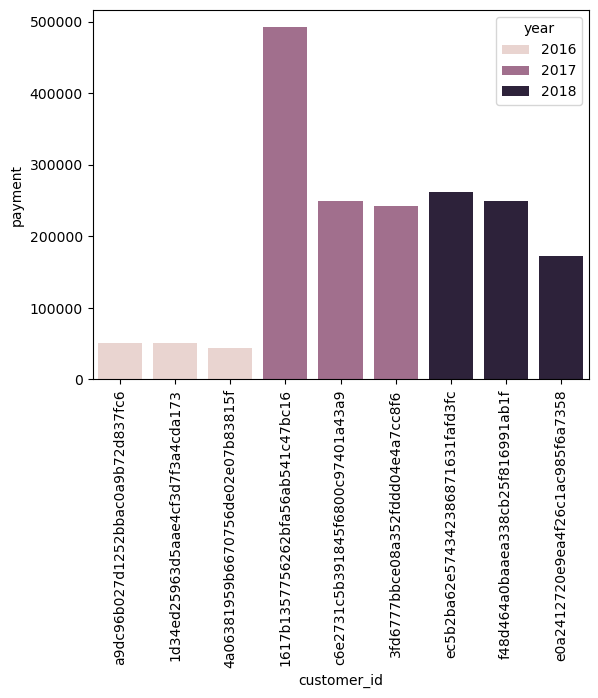

In [13]:
query=""" select customer_id,years,payment,d_rank from
(select orders.customer_id,sum(payments.payment_value) as payment,year(orders.order_purchase_timestamp) as years 
,dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on orders.order_id=payments.order_id group by  customer_id,years) as a where d_rank<=3 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','year','payment','d_rank'])
df
sns.barplot(x='customer_id',y='payment', data=df, hue='year')
plt.xticks(rotation=90)
plt.show()